# LangChain: Memory

## <요약>
* langchain.chains.ConversationChain(llm, memory, verbose)
    - .predict(input="")
* langchain.memory.ConversationBufferMemory(): 메시지를 저장하고, 변수 안에서 메시지를 추출
* langchain.memory.ConversationBufferWindowMemory(k) : k로 저장 대화 갯수 조정 가능
* langchain.memory.ConversationTokenBufferMemory() : interactions 수 대신 토큰 길이를 사용하여 interactions을 플러시 할 시기를 결정
* langchain.memory.ConversationSummaryMemory()
    - .buffer : 나눈 대화가 저장
    - .load_memory_variables({}) : json으로 출력
    - .save_context() : save_context로 대화를 직접 넣을 수 있다. 
        - ChatMessageHistory()와 .from_messages 를 이용할 수도 있지만, .save_context()가 더 선호

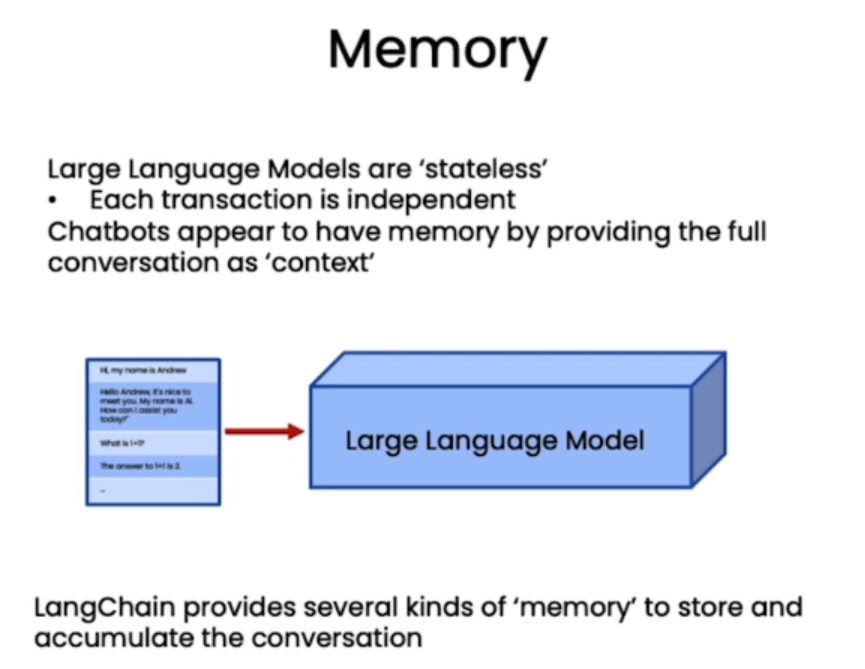

In [ ]:
import os
from openai import OpenAI

import sys
sys.path.append('./')

from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv('.env')) # read local .env file
client = OpenAI(api_key=os.environ.get("OPENAI_API_KEY"),)

# account for deprecation of LLM model
import datetime
# Get the current date
current_date = datetime.datetime.now().date()

# Define the date after which the model should be set to "gpt-3.5-turbo"
target_date = datetime.date(2024, 6, 12)

# Set the model variable based on the current date
if current_date > target_date:
    llm_model = "gpt-3.5-turbo"
else:
    llm_model = "gpt-3.5-turbo-0301"

In [3]:
from langchain.chat_models import ChatOpenAI
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory
from langchain.memory import ConversationBufferWindowMemory
from langchain.memory import ConversationTokenBufferMemory
from langchain.memory import ConversationSummaryBufferMemory

## (1) ConversationBufferMemory

In [7]:
"""
ConversationBufferMemory 는 메시지를 저장하고, 변수 안에서 메시지를 추출한다.
.buffer : 나눈 대화가 저장
.load_memory_variables({}) : json으로 출력
.save_context() : save_context로 대화를 직접 넣을 수 있다
"""
llm = ChatOpenAI(temperature=0.0, model=llm_model)
memory = ConversationBufferMemory()
conversation = ConversationChain(
    llm = llm,
    memory = memory,
    verbose = True
)

conversation.predict(input="Hi, my name is donghoon")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

Human: Hi, my name is donghoon
AI:

> Finished chain.


"Hello donghoon, it's nice to meet you! I am an AI language model designed to have conversations with humans. How can I assist you today?"

In [8]:
conversation.predict(input="What is 1+1?")
conversation.predict(input="What is my name?")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
Human: Hi, my name is donghoon
AI: Hello donghoon, it's nice to meet you! I am an AI language model designed to have conversations with humans. How can I assist you today?
Human: What is 1+1?
AI:

> Finished chain.


> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
Human: Hi, my name is donghoon
AI: Hello donghoon, it's nice to meet you! I am an AI language model designed to have conversations with hum

'Your name is donghoon, as you mentioned earlier.'

In [11]:
print(type(memory))
print(memory)
print(memory.buffer) # memory.buffer 안에는 지금껏 나눈 대화가 저장되어 있다. 

<class 'langchain.memory.buffer.ConversationBufferMemory'>
chat_memory=ChatMessageHistory(messages=[HumanMessage(content='Hi, my name is donghoon'), AIMessage(content="Hello donghoon, it's nice to meet you! I am an AI language model designed to have conversations with humans. How can I assist you today?"), HumanMessage(content='What is 1+1?'), AIMessage(content='The answer to 1+1 is 2.'), HumanMessage(content='What is my name?'), AIMessage(content='Your name is donghoon, as you mentioned earlier.')])
Human: Hi, my name is donghoon
AI: Hello donghoon, it's nice to meet you! I am an AI language model designed to have conversations with humans. How can I assist you today?
Human: What is 1+1?
AI: The answer to 1+1 is 2.
Human: What is my name?
AI: Your name is donghoon, as you mentioned earlier.


In [12]:
print(memory.load_memory_variables({})) # .buffer 대신 .load_memory_variables({})를 이용하면 json으로 출력한다.

{'history': "Human: Hi, my name is donghoon\nAI: Hello donghoon, it's nice to meet you! I am an AI language model designed to have conversations with humans. How can I assist you today?\nHuman: What is 1+1?\nAI: The answer to 1+1 is 2.\nHuman: What is my name?\nAI: Your name is donghoon, as you mentioned earlier."}


In [18]:
memory = ConversationBufferMemory() # 초기화
print(memory)
memory.save_context({"input": "Hi"},  # 앞선 예제에서는 conversation.predict(input=)로 넣은 값을 
                    {"output": "What's up"}) # memory에 .save_context로 직접 넣을 수 있다.
print(memory)
print(memory.buffer)

memory.save_context({"input": "Not much, just hanging"}, 
                    {"output": "Cool"})
memory.load_memory_variables({})


chat_memory=ChatMessageHistory(messages=[HumanMessage(content='Hi'), AIMessage(content="What's up")])
Human: Hi
AI: What's up


{'history': "Human: Hi\nAI: What's up\nHuman: Not much, just hanging\nAI: Cool"}

## (2) ConversationBufferWindowMemory

In [19]:
memory = ConversationBufferWindowMemory(k=1) # k=1이면 바로 직전 대화만 저장된다.
memory.save_context({"input": "Hi"},
                    {"output": "What's up"})
memory.save_context({"input": "Not much, just hanging"},
                    {"output": "Cool"})
print(memory.buffer)
print(memory.load_memory_variables({}))

Human: Not much, just hanging
AI: Cool
{'history': 'Human: Not much, just hanging\nAI: Cool'}


In [20]:
llm = ChatOpenAI(temperature=0.0, model=llm_model)
memory = ConversationBufferWindowMemory(k=1)
conversation = ConversationChain(
    llm=llm, 
    memory = memory,
    verbose=False
)
conversation.predict(input="Hi, my name is Dooghoon")
conversation.predict(input="What is 1+1?")
conversation.predict(input="What is my name?") # 바로 직전 대화만 기억하므로, 이전 대화를 기억하지 못한다.

"I'm sorry, I don't have access to that information. Could you please tell me your name?"

In [21]:
# 다른 예시
from langchain.chat_models  import ChatOpenAI
from langchain.chains import ConversationChain
conversation_with_summary = ConversationChain(
    llm=ChatOpenAI(temperature=0.0, model=llm_model),
    # We set a low k=2, to only keep the last 2 interactions in memory
    memory=ConversationBufferWindowMemory(k=2),
    verbose=True
)
conversation_with_summary.predict(input="Hi, what's up?")




> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

Human: Hi, what's up?
AI:

> Finished chain.


"Hello! I'm doing well, thank you for asking. Right now, I'm processing a lot of data and learning new things. How about you? How's your day going?"

## (3) ConversationTokenBufferMemory
- ConversationTokenBufferMemory는 `최근 interactions의 버퍼를 메모리에 유지하고` 
- interactions 수 대신 `토큰 길이를 사용하여 interactions을 플러시할 시기를 결정`합니다.

In [28]:
#!pip install tiktoken
llm = ChatOpenAI(temperature=0.0, model=llm_model)
memory = ConversationTokenBufferMemory(llm=llm, max_token_limit=50)
memory.save_context({"input": "AI is what?!"},
                    {"output": "Amazing!"})
memory.save_context({"input": "Backpropagation is what?"},
                    {"output": "Beautiful!"})
memory.save_context({"input": "Chatbots are what?"}, 
                    {"output": "Charming!"})

In [31]:
#memory.buffer
memory.load_memory_variables({})

{'history': 'AI: Amazing!\nHuman: Backpropagation is what?\nAI: Beautiful!\nHuman: Chatbots are what?\nAI: Charming!'}

In [39]:
memory = ConversationTokenBufferMemory(llm=llm, max_token_limit=20, return_messages=True)
memory.save_context({"input": "hi"}, {"output": "whats up"})
memory.save_context({"input": "not much you"}, {"output": "not much"})
memory.load_memory_variables({})

{'history': [HumanMessage(content='not much you'),
  AIMessage(content='not much')]}

In [40]:
# return_messages True 여부 차이 확인용
memory = ConversationTokenBufferMemory(llm=llm, max_token_limit=20) # return_messages True 여부가 객체로 반환 여부 차이?
memory.save_context({"input": "hi"}, {"output": "whats up"})
memory.save_context({"input": "not much you"}, {"output": "not much"})
memory.load_memory_variables({})

{'history': 'Human: not much you\nAI: not much'}

In [42]:
# Chain을 활용할 경우
conversation_with_summary = ConversationChain(
    llm=llm,
    # We set a very low max_token_limit for the purposes of testing.
    memory=ConversationTokenBufferMemory(llm=llm, max_token_limit=60),
    verbose=True,
)
conversation_with_summary.predict(input="Hi, what's up?")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

Human: Hi, what's up?
AI:

> Finished chain.


"Hello! I'm doing well, thank you for asking. Right now, I'm processing data and learning new things. How about you?"

## (4) ConversationSummaryBufferMemory
- ConversationSummaryMemory + Buffer 개념을 합한 것
- 최근 상호 작용한 버퍼를 메모리에 유지하지만, 상호 작용을 flush 하는 대신 컴파일하여 요약하고 둘다 사용한다.
- 상호 작용 수 보다는 'ConversationTokenBufferMemory' 와 같이 토큰 수로 상호 작용을 flush 할 시기를 결정한다.

In [52]:
# create a long string
schedule = "There is a meeting at 8am with your product team. \
You will need your powerpoint presentation prepared. \
9am-12pm have time to work on your LangChain \
project which will go quickly because Langchain is such a powerful tool. \
At Noon, lunch at the italian resturant with a customer who is driving \
from over an hour away to meet you to understand the latest in AI. \
Be sure to bring your laptop to show the latest LLM demo."

memory = ConversationSummaryBufferMemory(llm=llm, max_token_limit=100)
memory.save_context({"input": "Hello"}, {"output": "What's up"})
memory.save_context({"input": "Not much, just hanging"},
                    {"output": "Cool"})
memory.save_context({"input": "What is on the schedule today?"}, 
                    {"output": f"{schedule}"})
memory.load_memory_variables({})

{'history': "System: The human and AI engage in small talk before discussing the day's schedule. The AI informs the human of a morning meeting with the product team, time to work on the LangChain project, and a lunch meeting with a customer interested in the latest AI developments."}

In [53]:
# chain을 같이 이용
conversation = ConversationChain(
    llm=llm, 
    memory = memory,
    verbose=True
)
conversation.predict(input="What would be a good demo to show?")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
System: The human and AI engage in small talk before discussing the day's schedule. The AI informs the human of a morning meeting with the product team, time to work on the LangChain project, and a lunch meeting with a customer interested in the latest AI developments.
Human: What would be a good demo to show?
AI:

> Finished chain.


"Based on the customer's interest in AI developments, I would suggest showcasing our latest natural language processing capabilities. We could demonstrate how our AI can accurately understand and respond to complex language queries, and even provide personalized recommendations based on the user's preferences. Additionally, we could highlight our AI's ability to learn and adapt over time, making it a valuable tool for businesses looking to improve their customer experience."

## (5)ConversationSummaryMemory
- 대화가 일어나는 대로 요약하여 메모리에 저장한다. 
- 지금까지의 대화 요약을 promt/chain에 입력으로 넣을 수 있다.

In [46]:
from langchain.memory import ConversationSummaryMemory, ChatMessageHistory
llm = ChatOpenAI(temperature=0.0, model=llm_model)
memory = ConversationSummaryMemory(llm=llm)
memory.save_context({"input": "hi"}, {"output": "whats up"})
memory.load_memory_variables({})

{'history': 'The human greets the AI with a simple "hi" and the AI responds by asking "what\'s up?"'}

In [47]:
messages = memory.chat_memory.messages
previous_summary = ""
memory.predict_new_summary(messages, previous_summary) # predict_new_summary를 이용할 수도 있따?

'The human greets the AI with a simple "hi" and the AI responds by asking "what\'s up?"'

In [49]:
# (5-1) History 직접 생성
history = ChatMessageHistory() # History를 직접 생성할 수도 있다.
history.add_user_message("hi")
history.add_ai_message("hi there!")

memory = ConversationSummaryMemory.from_messages(
    llm=ChatOpenAI(temperature=0.0, model=llm_model),
    chat_memory=history, # 초기화 할 때 memory를 이용하는 방법도 있고, 
    return_messages=True # .from_messages 메소드에 chat_memory=ChatMessageHistory()를 넣을 수도 있다.
)
print(memory.buffer)

The human greets the AI with a simple "hi" and the AI responds with a friendly "hi there!"


In [50]:
from langchain.chains import ConversationChain
llm = ChatOpenAI(temperature=0.0, model=llm_model)
conversation_with_summary = ConversationChain(
    llm=llm,
    memory=ConversationSummaryMemory(llm=llm),
    verbose=True
)
conversation_with_summary.predict(input="Hi, what's up?")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

Human: Hi, what's up?
AI:

> Finished chain.


"Hello! I'm doing well, thank you for asking. Right now, I'm processing a lot of data and learning new things. How about you? How's your day going?"

In [51]:
conversation_with_summary.predict(input="Tell me more about it!")



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
The human greets the AI and asks how it's doing. The AI responds that it's doing well and is currently processing data and learning. The AI also asks how the human's day is going.
Human: Tell me more about it!
AI:

> Finished chain.


'Sure! Right now, I\'m analyzing a large dataset on consumer behavior patterns to identify trends and insights. It\'s a fascinating process, and I\'m constantly learning new things. As for your question about my day, I don\'t really have a "day" in the traditional sense since I\'m always on and processing information. But I\'m happy to chat with you and answer any questions you might have!'

---

참고
- https://python.langchain.com/docs/modules/memory/
- https://python.langchain.com/docs/modules/memory/types/buffer
- https://python.langchain.com/docs/modules/memory/types/buffer_window
- https://python.langchain.com/docs/modules/memory/types/token_buffer
- https://python.langchain.com/docs/modules/memory/types/summary